# Problem Definition:
0. Kaggle Forest Cover Type Prediction Challenge. (Originally UCI CoverType Dataset)
1. Multi-Class Classification Problem
2. Extremely sparse features present.
3. Perfectly Balanced classes in training set.
4. Simple Accuracy score used for Validation.

### Scores
0. Random Forest, Baseline All Features(54) - 0.74961.
0. XGBoost baseline all features - 0.764.
1. Random Forest, GridSearch Optimized Hyperparamters and 12 Selected Features - 0.73814.
2. XGBoost, Selected Features, hyperparamter optimization provides negligible improvement - 0.742.

### Target Data Description
Each observation is a 30m x 30m patch. You are asked to predict an integer classification for the forest cover type. The seven types eith their labels are:

1 - Spruce/Fir<br>
2 - Lodgepole Pine<br>
3 - Ponderosa Pine<br>
4 - Cottonwood/Willow<br>
5 - Aspen<br>
6 - Douglas-fir<br>
7 - Krummholz<br>

The training set (15120 observations) contains both features and the Cover_Type. (Just 2.6% of the data used for Training.)

### Training Features/Data

Data Fields: 

1. Elevation - Elevation in meters
2. Aspect - Aspect in degrees azimuth
3. Slope - Slope in degrees
4. Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features
5. Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features
6. Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway
7. Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
8. Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
9. Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice
10. Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points
11. Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
12. Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation
13. Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

pd.set_option('display.max_columns', 100)

In [160]:
train_path = 'Data/train.csv'
test_path = 'Data/test.csv'
submit_path = 'Data/sampleSubmission.csv'

In [161]:
dtrain = pd.read_csv(train_path, index_col=0)
dtest = pd.read_csv(test_path, index_col=0)

## Exploratory Data Analysis
1. Target Variable is perfectly Balanced.

In [5]:
#dtrain['Cover_Type'].value_counts()

#### Data Types and Null Values 
1. All Columns appear to be int64, no nan values.

In [6]:
#dtrain.info()

In [7]:
#for col in dtrain.columns:
    #print(f' {col} : {dtrain[col].isnull().sum()}')  

#### Data Description
1. Soil Type 15, 7 have no variation. Will not have any Predictive Power.

In [9]:
# Now this includes values for all classes, better to groupyby the target variable and then get description.
#dtrain.describe()

#### Skew Of Data 
1. Most continuous columns don't have major skew.
2. Many of the binary Soil Type Columns have large skews, large/long tails. These are sparse columns.

In [8]:
#print(dtrain.skew())

### Stats by each Cover Type
Visualizing the same stats later.

In [5]:
grouped_dataframe = dtrain.groupby(['Cover_Type'])
# Dictionary of the Cover_type and the label 

label_dict = {1 : 'Spruce/Fir', 2 : 'Lodgepole Pine', 3 : 'Ponderosa Pine', 4 : 'Cottonwood/Willow', 5 :
              'Aspen', 6 : 'Douglas-fir', 7 : 'Krummholz'}

In [76]:
#from IPython.display import display

#for cover in dtrain.Cover_Type.unique():
    #print(f'Forest Cover Type - {cover}')
    #display(grouped_dataframe.get_group(cover).describe())

## Visualizations

### Univariate analysis - Distributions of the continuous variables
1. Elevation has distinct distributions for most forest cover types, important feature.
2. Aspect - The cottonwood/willow and Aspen trees are bunched together more prominently below 180 degree azimuth and the Douglas fir grows at some crazy high azimuth values. Most of examples of the cover types follow a similar distribution.
3. The aspen, panderosa pine, cottonwood/willow and douglas fir grow over a wider range of sloped terrain. The rest tend to grow in less steep terrain.
4. The cotton willow mostly grows close to water features, to a higher extent than the other trees coverage types.
5. There are coverage types that generally grow closer to the roadways.
6. The hillshade features are highly correalted with the aspect and slope features, makes sense.
7. The cover type that are closer to roads are also closer to fire points, they seem to be correlated.

In [6]:
# Only continuous columns
d_train_cont=dtrain.iloc[:,:10] 

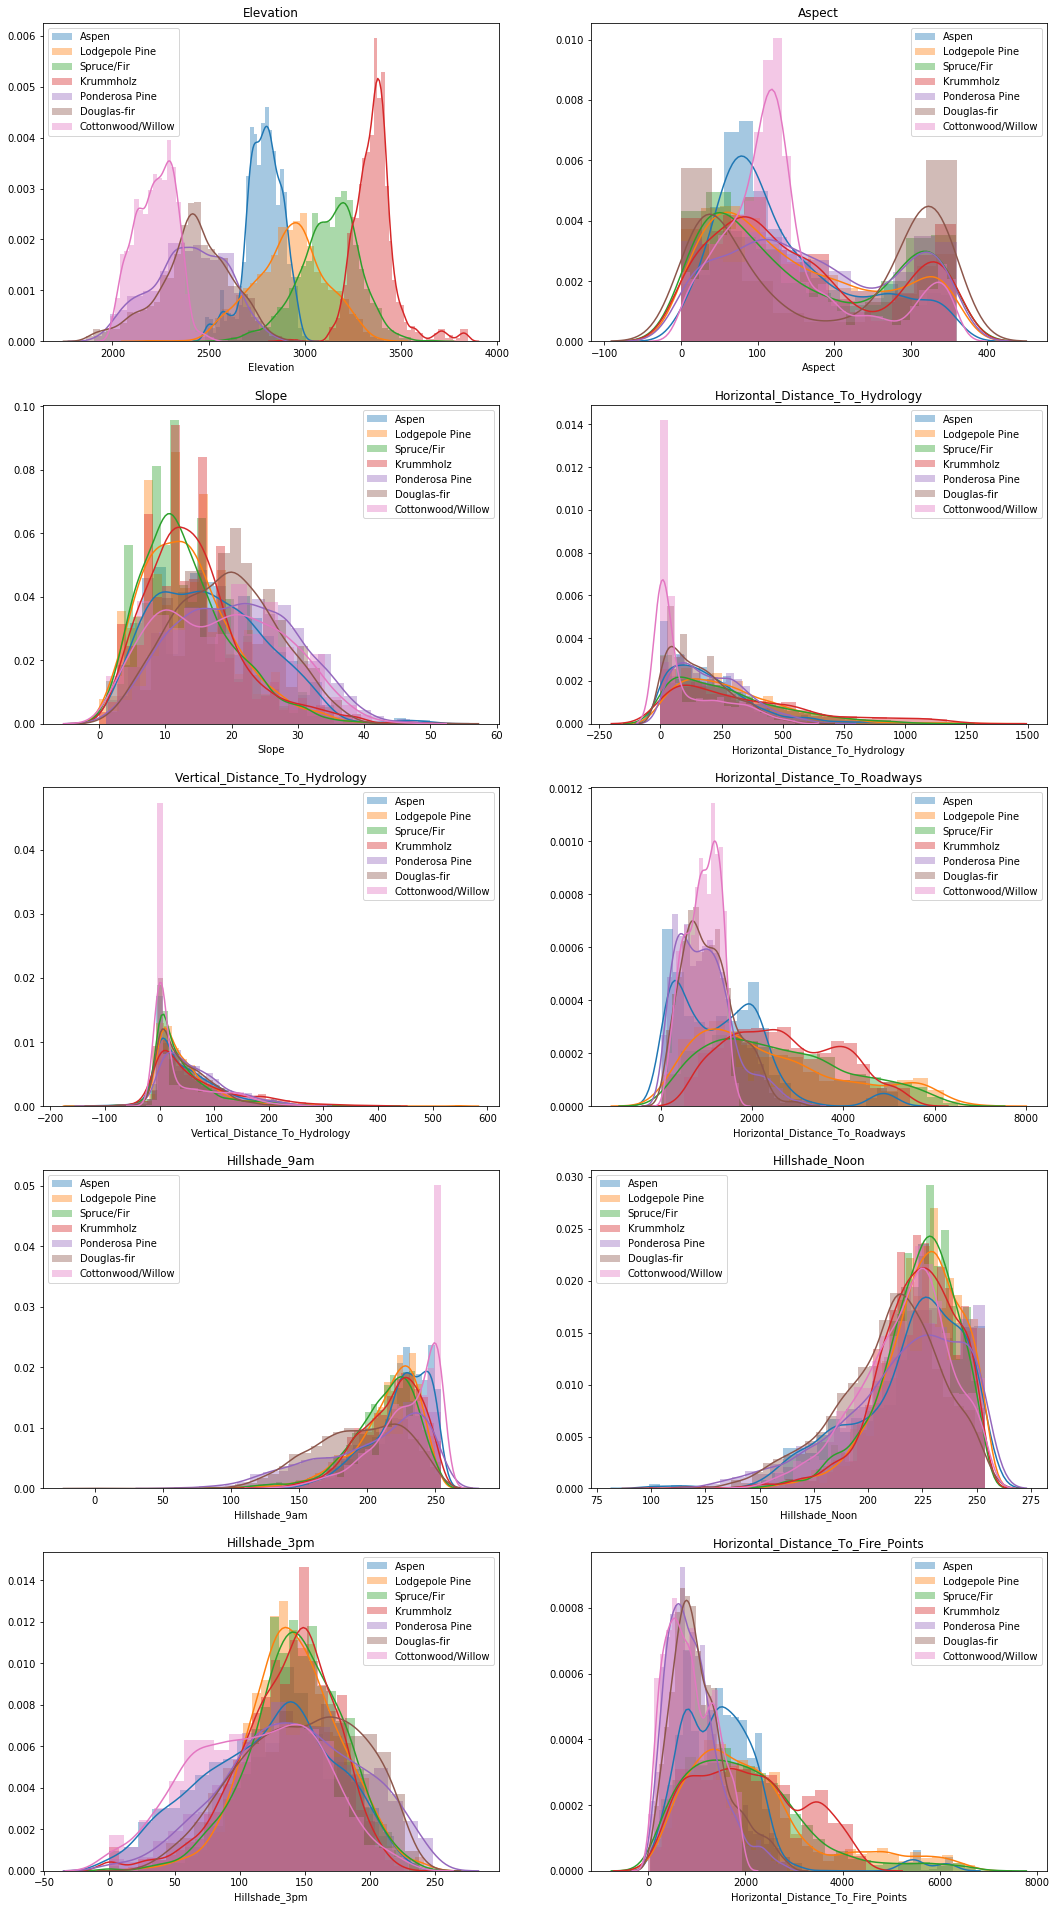

In [12]:
# To plot multiple distributions filtered by the target for each continuous variable.
import math 
targets = dtrain.Cover_Type.unique()
fig = plt.figure()
height = 34
width = 18
fig.set_figheight(height)
fig.set_figwidth(width)
for i, col in enumerate(d_train_cont.columns):
    ax = fig.add_subplot(math.ceil(len(d_train_cont.columns.to_list())/2), 2, i+1) 
    for cover_type in targets:
        temp = d_train_cont.loc[dtrain.Cover_Type == cover_type]
        sns.distplot(temp[col], label = label_dict[cover_type])
    ax.legend()
    ax.set_title(col)
#plt.savefig('Graph/Univariate_cont_dist.jpg')
plt.show()

### Bivariate Analysis with the Coverage_Type
Violin plot to get both Distribution and Boxplot.
1. Useful for identifying features that have distinct classes for the coverage type, slighty easier to see than distribution plots with hue.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


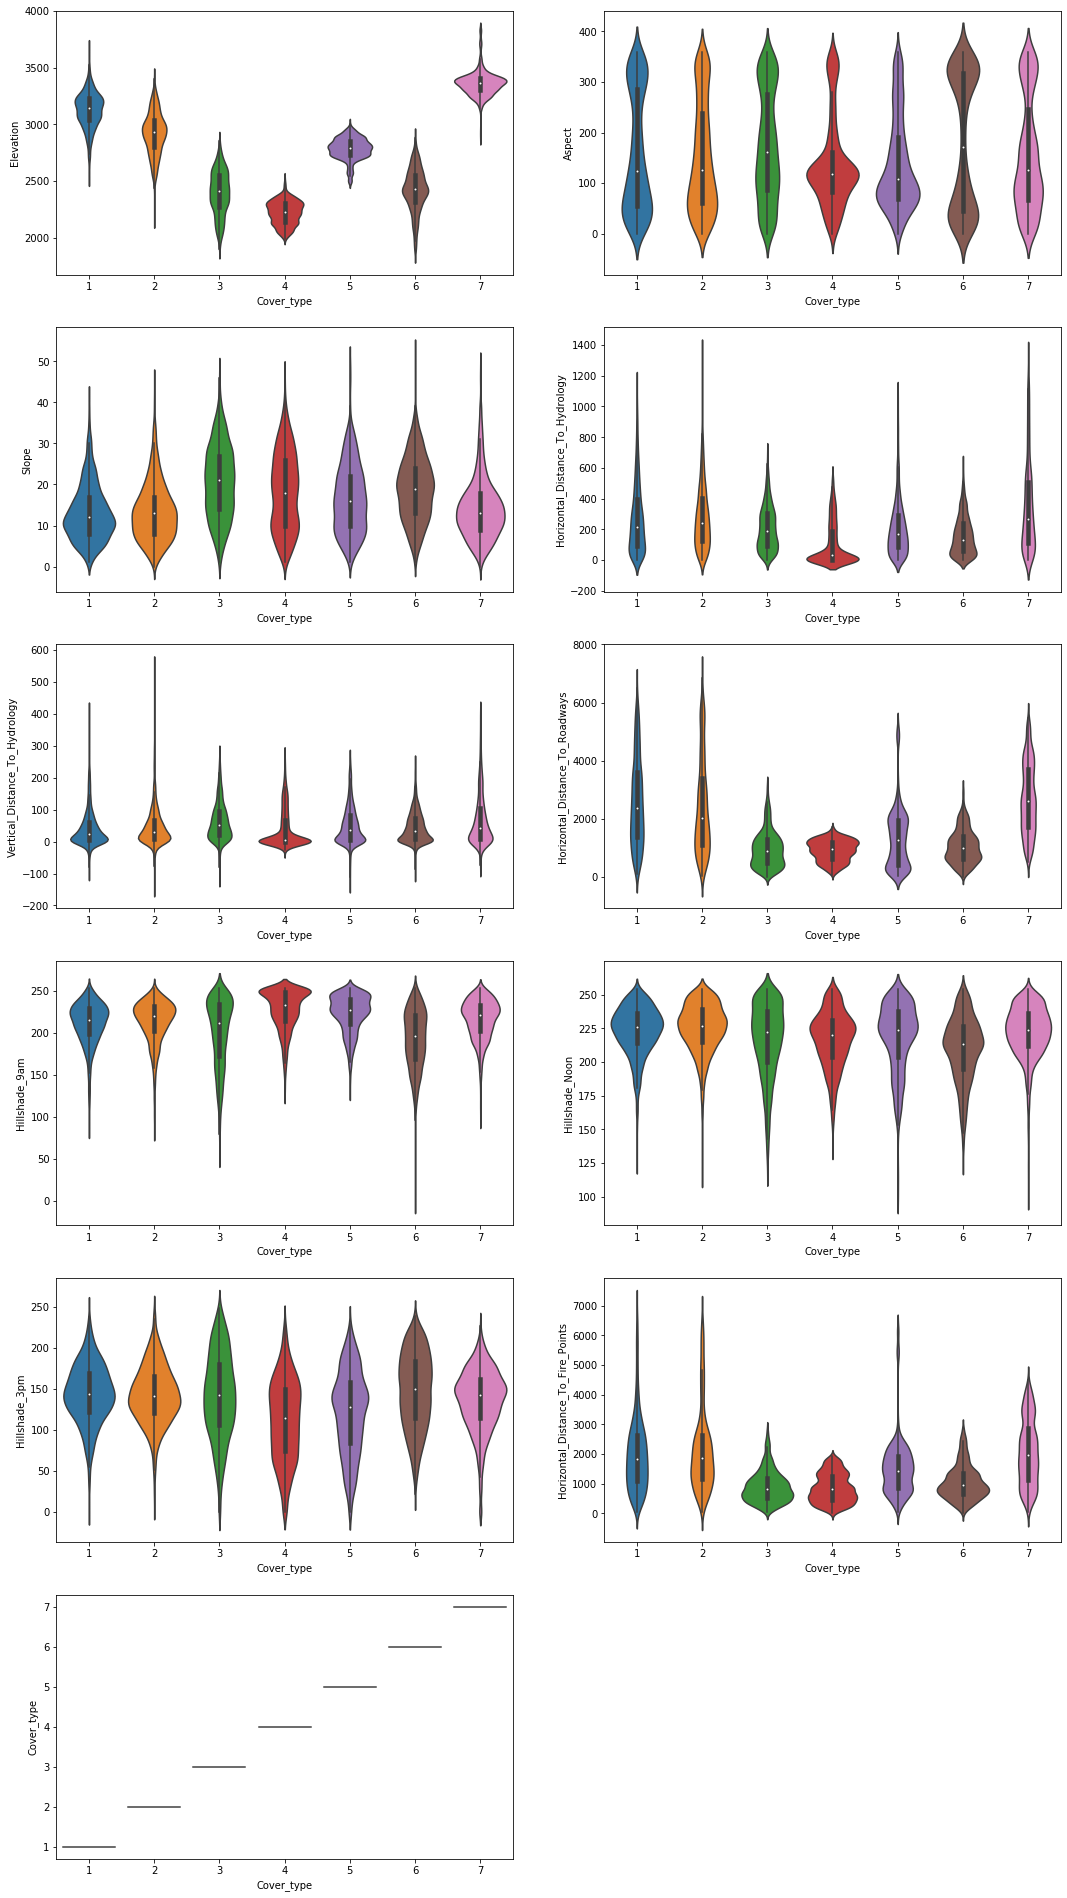

In [13]:
d_train_cont['Cover_type'] = dtrain.Cover_Type
fig = plt.figure()
fig.set_figheight(34)
fig.set_figwidth(18)

for i, item in enumerate(d_train_cont.columns.to_list()):
    fig.add_subplot(math.ceil(len(d_train_cont.columns.to_list())/2), 2, i+1)
    sns.violinplot(y= item, x = 'Cover_type', data = d_train_cont)

#plt.savefig('Graph/Bivariate_feat_cover.jpg')
plt.show()

## Correlation Analysis - Pearson's correlation for Continuous Variables.

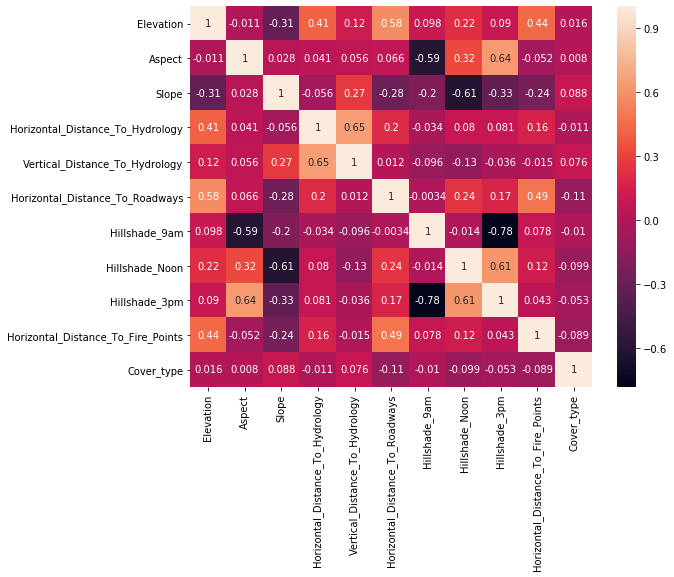

In [14]:
# Correlation heatmap would be too large, find largest correlations.
plt.figure(figsize=(9, 7))
sns.heatmap(d_train_cont.corr(),annot=True, cbar = True)

### Finding Highest Absolute Correlations

In [15]:
# 2nd Method, get all corrrelations and corresponding rows and columns in numpyarray from the top triangle
# of matrix. Then sort this array.

corr_list = []
for row_num, row in enumerate(d_train_cont.corr().index):
    for col_num, col in enumerate(d_train_cont.corr().index):
        # Ignoring comparison between the same columns
        if col_num > row_num:
            corr_list.append([row, col, np.abs(d_train_cont.corr().iloc[row_num, col_num])])
            
corr_array = np.array(corr_list)
corr_array = corr_array[corr_array[:,2].argsort()][::-1]
corr_array[:10]

array([['Hillshade_9am', 'Hillshade_3pm', '0.779964742447544'],
       ['Horizontal_Distance_To_Hydrology',
        'Vertical_Distance_To_Hydrology', '0.6521424712357364'],
       ['Aspect', 'Hillshade_3pm', '0.635022364019874'],
       ['Hillshade_Noon', 'Hillshade_3pm', '0.6145263872475779'],
       ['Slope', 'Hillshade_Noon', '0.6126128724172692'],
       ['Aspect', 'Hillshade_9am', '0.5939974281313112'],
       ['Elevation', 'Horizontal_Distance_To_Roadways',
        '0.5786589907340067'],
       ['Horizontal_Distance_To_Roadways',
        'Horizontal_Distance_To_Fire_Points', '0.48638564505875065'],
       ['Elevation', 'Horizontal_Distance_To_Fire_Points',
        '0.4435634307597476'],
       ['Elevation', 'Horizontal_Distance_To_Hydrology',
        '0.4127115202982467']], dtype='<U34')

## Data Interaction and Selecting Useful Features 
1. Between Hillshade_9am' and 'Hillshade_3pm'. - Very high negative correlation. Different hillshade index for coverage types maybe due to growth at different elevation. The classes of the target do appear to be in narrow bands.
2. Horizontal_Distance_To_Hydrology' and 'Vertical_Distance_To_Hydrology'. - Strong positive correlation, signifies that certain coverage types survive further away from water sources, the Krummholz for example, the willow appears to grow closer to water sources. Relationship looks weakly linear.
3. 'Aspect' and 'Hillshade_3pm'. - Interaction of the Sun's position and the aspect of the trees along with the resulting hillshade can be seen beautifully using these plots. The height of the trees must have an impact too and is possibly why we do see that the cottonwood willow is on the lower end of providing shade compared to the doghlas-fir and the krummholz.
4. 'Aspect' and 'Hillshade_9am'.
5. Slope' and 'Hillshade_Noon'. At noon, with the sun overhead, we see that the resulting hillshade must be an interaction of the slope of the trees, its height and the elevation. The trees standing straight provide the most shade when the sun is overhead. 
6. 'Elevation' and 'Horizontal_Distance_To_Roadways'. - shows pretty distinct classes of the coverage types, important features. Also makes sense that the types growing at high altitudes are further away from roads i.e less roads up high.
7. Elevation and Horizontal_Distance_To_Fire_Points - Comparing with the above interaction, we can see that this is pretty similar, so most fire points are closer to roads, towns, civilisation. Except for maybe the lodgepole pine and cotton willow, posssible these are more susceptible to forrest fires due to extreme heat, other reasons.
7. Horizontal_Distance_To_Roadways and Horizontal_Distance_To_Fire_Points. - Also reaffirms the hypothesis that the lodgepole pine and cotton willow are more susceptible to fire points further away from civilisation i.e. other factors at play.
8. Elevation and Horizontal_Distance_To_Fire_Points - Also shows that the Lodgepole Pine, aspen and Krummholz can grow further away from water sources, a cluster of krummholz can be seen growing in extreme conditions.

### Visualising strongest Correlations

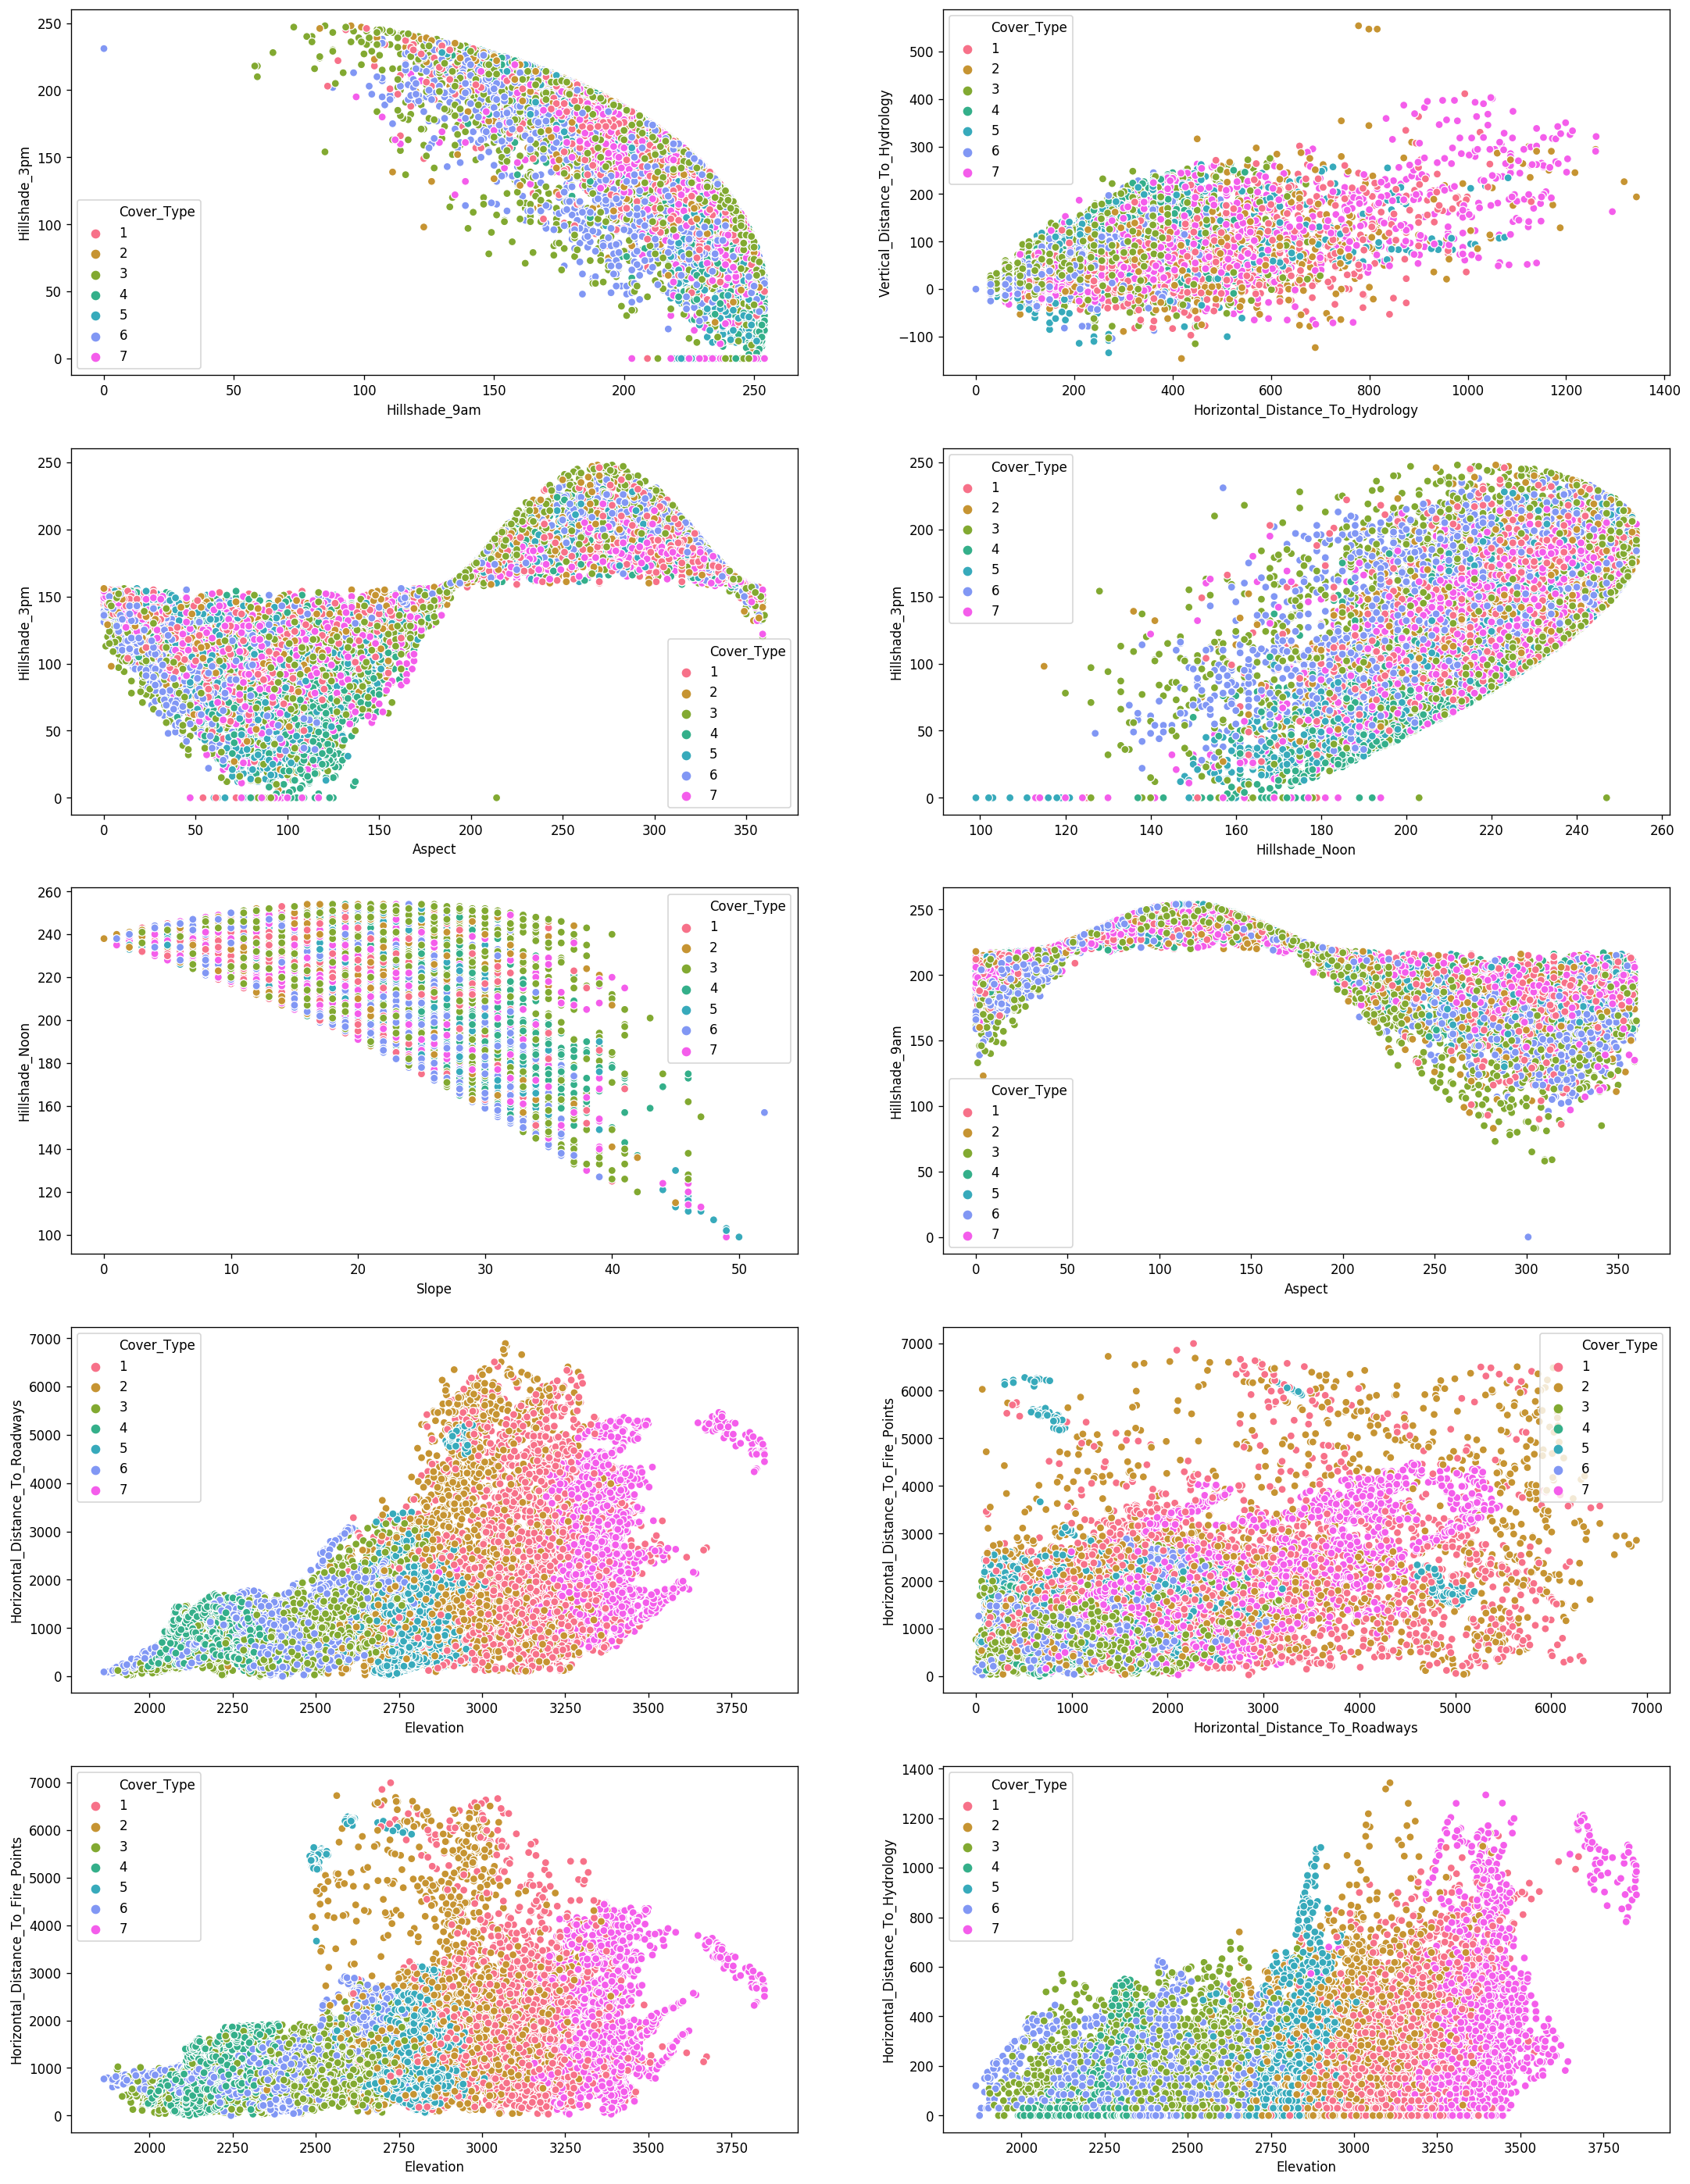

In [19]:
# Iterating over the corr_array array and then using the column names from the 1st, 2nd element of list.
# create new figure and add subplots inside loop
fig = plt.figure()

fig.set_figheight(30)
fig.set_figwidth(22)
fig.set_dpi(120)
for i, item in enumerate(corr_array[:10]):
    fig.add_subplot(math.ceil(len(corr_array[:10])/2), 2, i+1 )
    sns.scatterplot(x = item[0], y = item[1], data = dtrain, hue = 'Cover_Type', legend = 'full', palette=sns.husl_palette(7))
plt.savefig('Graph/data_interaction.jpg')
plt.show()

### Visualizing Binary Features.
1. Wilderness Area 1 and 4 seem to be good discrminators of the cover types (distinct classes). 
2. Soil types 3, 10, 29, 38 appear to be good discriminators for certain classes. lodgepole pine recall is very low compared to others, soil type 4 could be useful.

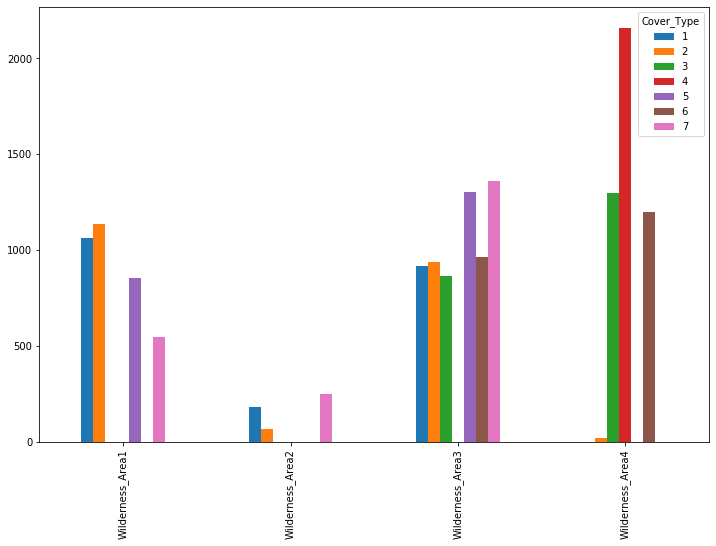

In [18]:
# Filter cover type and then barplot of wilderness area to see if any trees grow exclusively in a region.
#data.describe()
data = dtrain.groupby(['Cover_Type'])[['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']].sum()
# Transpose to get numbers by wilderness type.
data.T.plot(kind = 'bar', figsize = (12,8))

In [ ]:
# Drop Soil type 15,7 - They have no variation. 
dtrain.drop(['Soil_Type7', 'Soil_Type15'], axis = 1, inplace = True)
# filtering all columns that contain the str Soil
soil_columns = dtrain.columns[dtrain.columns.str.contains('Soil')].to_list()

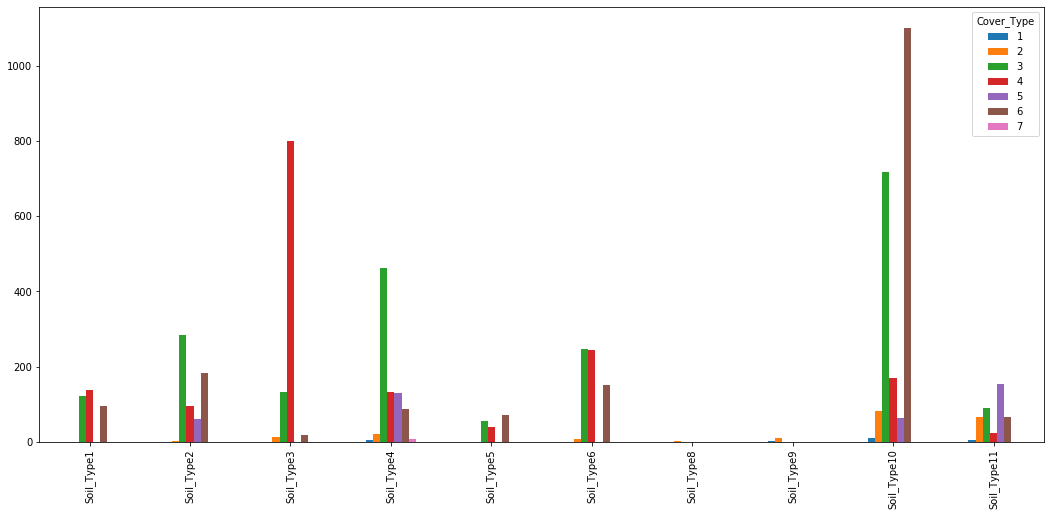

In [211]:
data_soil = dtrain.groupby(['Cover_Type'])[soil_columns[:10]].sum()
data_soil.T.plot(kind = 'bar', figsize = (18,8))

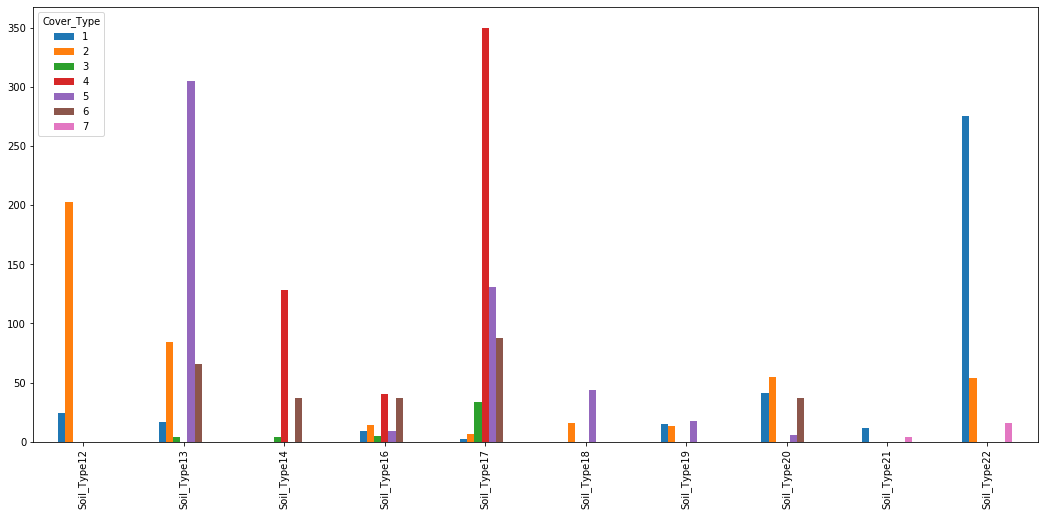

In [212]:
data_soil = dtrain.groupby(['Cover_Type'])[soil_columns[10:20]].sum()
data_soil.T.plot(kind = 'bar', figsize = (18,8))

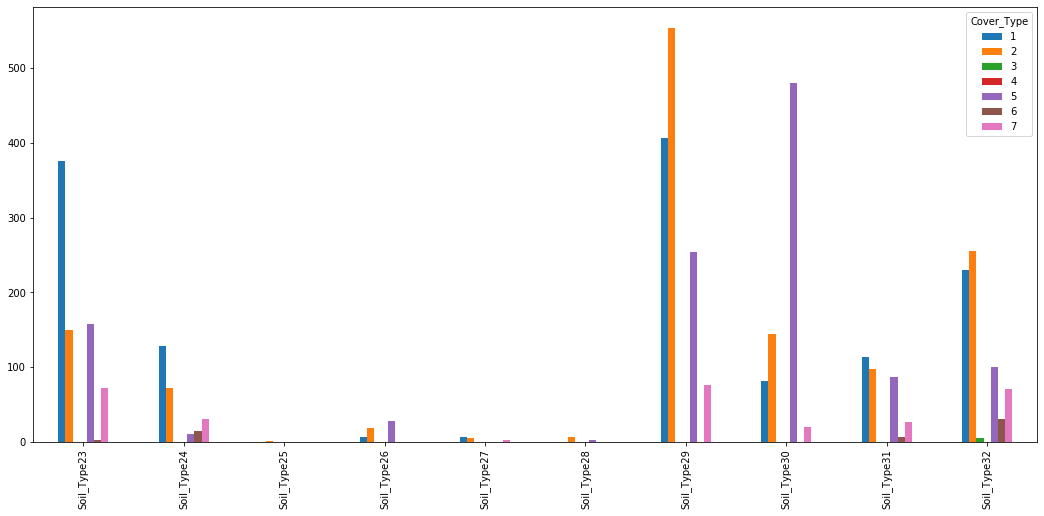

In [214]:
data_soil = dtrain.groupby(['Cover_Type'])[soil_columns[20:30]].sum()
data_soil.T.plot(kind = 'bar', figsize = (18,8))

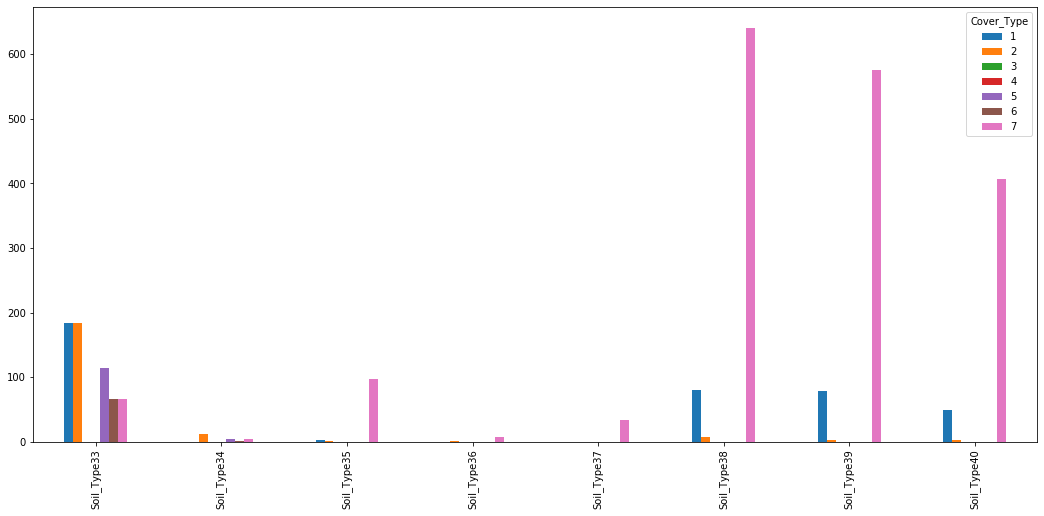

In [215]:
data_soil = dtrain.groupby(['Cover_Type'])[soil_columns[30:]].sum()
data_soil.T.plot(kind = 'bar', figsize = (18,8))

# Modelling - Predictions, Analysis.
Using Tree Based Models : 
1. Decesion Tree Classifier.
2. Random Forrest Classifier.(Bagging)
3. XGBoost Classifier.(Boosting)

#### Preparing Data

In [25]:
label = dtrain['Cover_Type']
dtrain.drop(['Cover_Type'], axis = 1, inplace=True)

In [80]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#### Train - Test Split

#### Feature selection from EDA and Running Random Forest Using All Features.

In [29]:
x_train, x_test, y_train, y_test = train_test_split(dtrain, label, test_size = .3)
dirty_clf = RandomForestClassifier()
dirty_clf.fit(x_train, y_train)
print(dirty_clf.score(x_test, y_test))
imp_feat = pd.DataFrame(index= dtrain.columns.to_list() , data= dirty_clf.feature_importances_)
imp_feat.rename(columns={0 : 'Importance'}, inplace=True)
imp_feat.sort_values(by='Importance', axis =0, ascending=False)[:15]

0.8505291005291006


Importance
Elevation                             0.219891
Horizontal_Distance_To_Roadways       0.094794
Horizontal_Distance_To_Fire_Points    0.073273
Horizontal_Distance_To_Hydrology      0.063541
Hillshade_9am                         0.052095
Vertical_Distance_To_Hydrology        0.052055
Aspect                                0.050391
Wilderness_Area4                      0.047494
Hillshade_3pm                         0.046943
Hillshade_Noon                        0.045563
Slope                                 0.038742
Soil_Type10                           0.024401
Soil_Type38                           0.018138
Soil_Type39                           0.017731
Soil_Type3                            0.017356

#### Final Selected Features
Selected from EDA and dirty random forest model.

In [51]:
baseline_features = ['Elevation', 'Horizontal_Distance_To_Roadways']
features = ['Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Hydrology',
            'Horizontal_Distance_To_Fire_Points', 'Aspect','Wilderness_Area1', 'Wilderness_Area4', 'Soil_Type3',
            'Soil_Type4','Soil_Type10', 'Soil_Type29',
            'Soil_Type38']
x_train, x_test, y_train, y_test = train_test_split(dtrain[features], label, test_size = .3)

## Decision Tree

#### Analysis of performance while selecting features:
0. Baseline Using All Features - f1 score of 71.89
1. Using the features - 'Elevation', 'Horizontal_Distance_To_Roadways' - Strong performance with Krummhoz, Cottonwood willow, Aspen., GridSearchCV Optimized f1 score 0.62.
2. Adding Feature - 'Horizontal_Distance_To_Hydrology' should boost aspen score. - f1 score 0.66, Did boost aspen score, in fact all scores boosted except spruce/fir that went down.
3. Adding Feature - Aspect should boost score of cottonwood willow and douglas fir. - f1 score  0.69, did boost score those 2 cottonwood now the strongest point of classifer. Aspen only one down marginally on precision. 
4. Adding Feature - slope might somewhat improve score of lodgepole pine. - f1 score 0.6818, boosted score of Aspen and Douglas-fir, rest all down.
5. Add feature - Hillshade_9am - should imprive doughlas fir score  - f1 score 0.6848.
6. Overall just manually selecting features from EDA and Visualization produces a classifier okay at calssifying cottonwood, aspen, krumholtz with high precision and recall.

#### Hyper Parameter Optimization using  GridSearchCV for Decision Tree and initial 2 features.
1. max_depth = 8, best F1 Score. 61.78
2. min_samples_split - Doesn't seem to have much effect, just fewer leaves, but lower accuracy. Keep default. 
3. min_samples_leaf - Doessn't seem to do much, just fewer leaves, but lower accuracy. keep default.
4. class_weight: balanced - not much effect, is expected as the classes are balanced.
5. max_leaf_nodes : forcing to max 8, results in 6 selected, accuracy only drops slightly (.57) but f1 score drops and some classes not predicted.
6. Selecting between entropy and gini doesn't change much.

In [52]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=8, min_samples_split=2, class_weight= None, max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,)

In [53]:
grid_params = {'criterion' : ["gini", "entropy"]}
grid = GridSearchCV(estimator=clf, param_grid=grid_params, n_jobs=-1, cv = 5)
grid.fit(x_train, y_train)
grid.score(x_test, y_test)

0.716931216931217

In [54]:
grid.best_estimator_
y_pred = grid.predict(x_test)

In [55]:
clf.fit(x_train, y_train)
print(f'No of Leaves : {clf.get_n_leaves()}')
clf.feature_importances_

No of Leaves : 194


array([0.61484564, 0.07295757, 0.08113806, 0.06719101, 0.04376349,
       0.02628246, 0.00534225, 0.00745846, 0.02011824, 0.05563146,
       0.0028877 , 0.00238366])

#### Metrics

In [56]:
# With the Selected Features.
print(classification_report(y_test, y_pred, labels= list(label_dict.keys()), target_names=list(label_dict.values())))

                   precision    recall  f1-score   support

       Spruce/Fir       0.62      0.63      0.63       655
   Lodgepole Pine       0.69      0.43      0.53       663
   Ponderosa Pine       0.72      0.52      0.60       630
Cottonwood/Willow       0.90      0.90      0.90       662
            Aspen       0.71      0.85      0.77       644
      Douglas-fir       0.59      0.77      0.67       654
        Krummholz       0.81      0.92      0.86       628

         accuracy                           0.72      4536
        macro avg       0.72      0.72      0.71      4536
     weighted avg       0.72      0.72      0.71      4536



## Random Forest Classifier

1. Using Selected Features and Optimized Hyperparameters - max_depth = 18, n_estimators = 127, validation score of 0.85. Kaggle Score of 0.73814

In [98]:
rnd_clf = RandomForestClassifier()
grid_params_1 = {'max_depth' : [18], 'n_estimators' : [127], 'criterion':['entropy']}
grid = GridSearchCV(estimator=rnd_clf, param_grid=grid_params_1, n_jobs=-1, cv = 5)
grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [101]:
print(grid.best_score_)
print(grid.score(x_test, y_test))
#grid.cv_results_
#grid.best_estimator_

0.840324611369122
0.8527336860670194


In [105]:
final_clf = RandomForestClassifier(max_depth=18, n_estimators=127, criterion='entropy')
final_clf.fit(x_train, y_train)
print(final_clf.score(x_train, y_train))
print(final_clf.score(x_test, y_test))
y_hat = final_clf.predict(x_test)

0.99848828420257
0.8518518518518519


#### Metrics

In [106]:
print(classification_report(y_test, y_hat, target_names=label_dict.values()))

                   precision    recall  f1-score   support

       Spruce/Fir       0.77      0.71      0.74       655
   Lodgepole Pine       0.78      0.66      0.71       663
   Ponderosa Pine       0.84      0.84      0.84       630
Cottonwood/Willow       0.93      0.97      0.95       662
            Aspen       0.86      0.95      0.90       644
      Douglas-fir       0.85      0.88      0.87       654
        Krummholz       0.90      0.97      0.93       628

         accuracy                           0.85      4536
        macro avg       0.85      0.85      0.85      4536
     weighted avg       0.85      0.85      0.85      4536



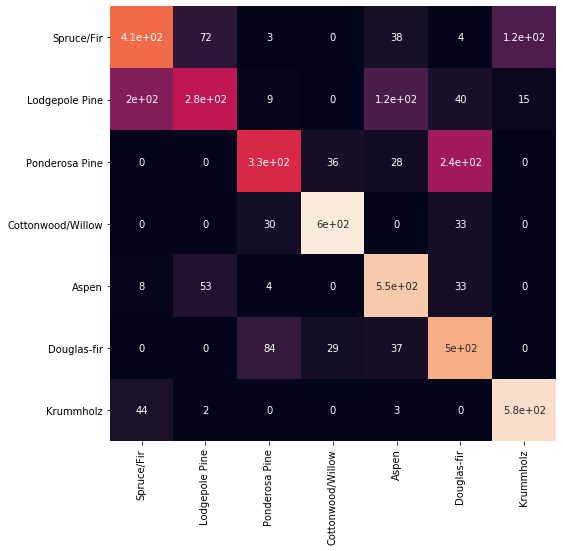

In [107]:
plt.figure(figsize=(8,8))
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred),
                         index = label_dict.values(), columns= label_dict.values()), annot=True, cbar = False)
plt.show()

In [108]:
imp_feat = pd.DataFrame(index= features , data= final_clf.feature_importances_)
imp_feat.rename(columns={0 : 'Importance'}, inplace=True)
imp_feat.sort_values(by='Importance', axis =0, ascending=False)

Importance
Elevation                             0.383510
Horizontal_Distance_To_Roadways       0.133294
Wilderness_Area4                      0.100118
Horizontal_Distance_To_Fire_Points    0.099654
Horizontal_Distance_To_Hydrology      0.087843
Aspect                                0.081905
Wilderness_Area1                      0.034830
Soil_Type10                           0.027791
Soil_Type3                            0.017038
Soil_Type4                            0.014135
Soil_Type38                           0.013563
Soil_Type29                           0.006318

## XGBoost Classifier
1. Hyperparameter Optimization had negligible improve in score for large train time hits. Kept default, still best performing method.

In [154]:
xgb_clf = XGBClassifier(n_estimators=100, max_depth = 12)

In [115]:
#grid_params = {'max_depth' : [12,14,16]}
#grid_xgb = GridSearchCV(xgb_clf, grid_params, cv= 5)
#grid_xgb.fit(x_train, y_train)
#print(grid_xgb.best_score_)
#grid_xgb.cv_results_
#grid_xgb.score(x_test, y_test)

In [155]:
xgb_clf.fit(x_train, y_train)
xgb_clf.score(x_test, y_test)

0.8472222222222222

#### Metrics

In [156]:
y_pred = xgb_clf.predict(x_test)

In [158]:
print(classification_report(y_test, y_pred, target_names=label_dict.values()))

                   precision    recall  f1-score   support

       Spruce/Fir       0.75      0.72      0.74       655
   Lodgepole Pine       0.76      0.68      0.72       663
   Ponderosa Pine       0.82      0.84      0.83       630
Cottonwood/Willow       0.93      0.97      0.95       662
            Aspen       0.88      0.93      0.90       644
      Douglas-fir       0.86      0.85      0.85       654
        Krummholz       0.91      0.95      0.93       628

         accuracy                           0.85      4536
        macro avg       0.84      0.85      0.85      4536
     weighted avg       0.84      0.85      0.85      4536



#### Predictions on test set and Visualizations.

In [138]:
# Final Fit
xgb_clf.fit(dtrain[features], label)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [139]:
y_test_hat = xgb_clf.predict(dtest[features])

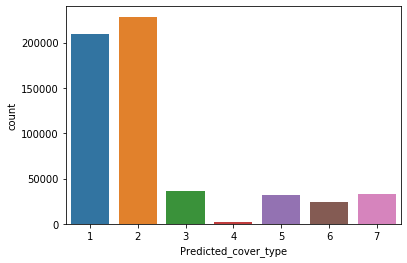

In [140]:
dtest['Predicted_cover_type'] = y_test_hat
sns.countplot(x = 'Predicted_cover_type', data = dtest)

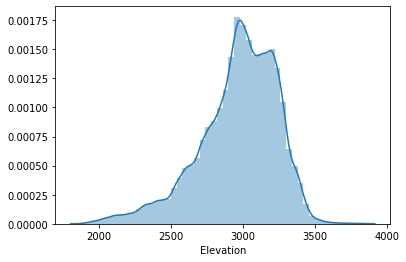

In [141]:
sns.distplot(dtest.Elevation)

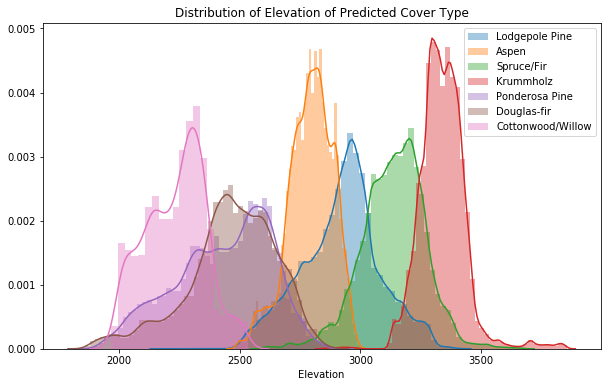

In [159]:
test_targets = dtest.Predicted_cover_type.unique()
plt.figure(figsize=(10,6))
for target in test_targets:
    temp = dtest.loc[dtest.Predicted_cover_type == target]
    sns.distplot(temp.Elevation, label = label_dict[target])

plt.legend()
plt.title('Distribution of Elevation of Predicted Cover Type')
plt.savefig('Graph/Predicted_classes.jpg')
plt.show()

#### Submitting to Kaggle

In [665]:
df_submit = pd.read_csv(submit_path, index_col=0)
df_submit['Cover_Type'] =y_test_hat
df_submit.to_csv('submit_kaggle.csv')